# Pre-trained ResNet50 - Image Classifier - Transfer Learning - Tensorflow

## Comparison with other network architecures 

<div align="center">
<img src="https://www.researchgate.net/profile/Tiago-Carvalho-8/publication/330478807/figure/fig1/AS:756995804110849@1557493272678/VGG16-VGG19-Inception-V3-Xception-and-ResNet-50-architectures.ppm" >
</div>

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import Model

# print("TF version:", tf.__version__)
# print("Hub version:", hub.__version__)
# print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive' )

Mounted at /content/drive


In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/deepStenosisDataset/original/' 

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

## Generators

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.30)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/deepStenosisDataset/original', 
    subset="validation", 
    classes = ['stenosis', 'non-stenosis'], 
    shuffle=False, 
    **dataflow_kwargs)

do_data_augmentation = True

if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/deepStenosisDataset/original', 
    subset="training", 
    classes = ['stenosis', 'non-stenosis'], 
    shuffle=True, 
    **dataflow_kwargs)


# train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
# valid_generator = valid_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

# print(train_generator.num_classes)

Found 598 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


In [ ]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=True)  # Do not include the ImageNet classifier at the top.

# base_model.trainable = False

# base_model.summary()

In [ ]:
# binary classifier
# x = tf.keras.layers.Dense(2,activation='sigmoid')(base_model.layers[-2].output) 
x = tf.keras.layers.Dense(2,activation='softmax')(base_model.layers[-2].output) 

# original classifier with 1000 neurons
# x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(base_model.layers[-3].output)
# x = tf.keras.layers.Dense(1000, activation='softmax', name='predictions')(x)

model = Model(base_model.inputs,outputs=x)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5), #SGD nao é boa (https://user-images.githubusercontent.com/11681225/49325458-fc785480-f585-11e8-8d2a-9012d6024c6e.gif) -> estudar mais sobre isso
  # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),  # CategoricalCrossentropy -> estudar mais sobre isso
  # metrics=['accuracy'])
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=70, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


43/43 [==============================] - 26s 493ms/step - loss: 0.7329 - binary_accuracy: 0.5409 - val_loss: 0.7818 - val_binary_accuracy: 0.5191
Epoch 2/70
43/43 [==============================] - 20s 470ms/step - loss: 0.6815 - binary_accuracy: 0.5789 - val_loss: 0.9183 - val_binary_accuracy: 0.5191
Epoch 3/70
43/43 [==============================] - 20s 470ms/step - loss: 0.6415 - binary_accuracy: 0.6440 - val_loss: 0.9760 - val_binary_accuracy: 0.5191
Epoch 4/70
43/43 [==============================] - 20s 465ms/step - loss: 0.6036 - binary_accuracy: 0.7018 - val_loss: 1.0839 - val_binary_accuracy: 0.5191
Epoch 5/70
43/43 [==============================] - 20s 466ms/step - loss: 0.5544 - binary_accuracy: 0.7346 - val_loss: 1.1132 - val_binary_accuracy: 0.5191
Epoch 6/70
43/43 [==============================] - 20s 465ms/step - loss: 0.5326 - binary_accuracy: 0.7478 - val_loss: 1.1103 - val_binary_accuracy: 0.5191
Epoch 7/70
43/43 [==============================] - 20s 467ms/step - 

## Confusion matrix

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 432x288 with 0 Axes>

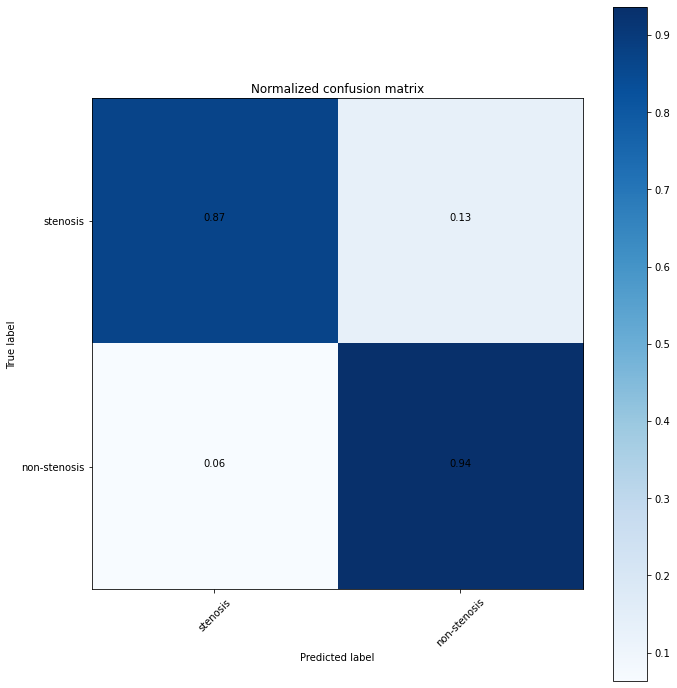

In [ ]:
# show the confusion matrix of our predictions
# https://www.kaggle.com/emrecetin/francois-cnn-model-on-covid-19-images
# IMAGE_SIZE = (150, 150)

# BATCH_SIZE = 32

# datagen_kwargs = dict(rescale=1./255, validation_split=.30)
# dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#                    interpolation="bilinear")

# test_data = tf.keras.preprocessing.image.ImageDataGenerator(
#     **datagen_kwargs)

# test_data_gen = test_data.flow_from_directory(
#     '/content/drive/MyDrive/Colab Notebooks/deepStenosisDataset/original', subset="validation", classes = ['stenosis', 'non-stenosis'], shuffle=False, **dataflow_kwargs)

# compute predictions
predictions = model.predict_generator(generator=valid_generator)
y_pred = [np.argmax(probas) for probas in predictions]
# y_pred =  model.predict(train_generator, batch_size=None).flatten()

y_test = valid_generator.classes
class_names = valid_generator.class_indices.keys()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       299
           1       0.88      0.94      0.90       299

    accuracy                           0.90       598
   macro avg       0.90      0.90      0.90       598
weighted avg       0.90      0.90      0.90       598



In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Print f1, precision, and recall scores
print('precision', precision_score(y_test, y_pred , average="macro"))
print('recall', recall_score(y_test, y_pred , average="macro"))
print('f1 score1', f1_score(y_test, y_pred , average="macro"))

precision 0.9033273381294964
recall 0.9013377926421404
f1 score1 0.901215971419212


In [ ]:

# print('Confusion matrix:\n', cnf_matrix)

# specificity = tn / (tn+fp)
print('sensitivity', cnf_matrix[0, 0] / (cnf_matrix[0, 1] + cnf_matrix[0, 0]))

# sensitivity = tp / (tp+fn)
print('specificity', cnf_matrix[1, 1] / (cnf_matrix[1, 1] + cnf_matrix[1, 0]))

tn, fp = cnf_matrix[0]
fn, tp = cnf_matrix[1]

# print(specificity)
# print(sensitivity)

sensitivity 0.8662207357859532
specificity 0.9364548494983278


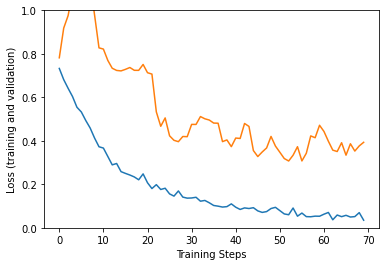

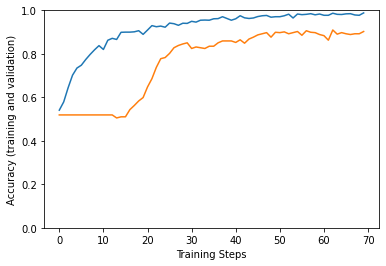

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["binary_accuracy"])
plt.plot(hist["val_binary_accuracy"])

## Save Model

In [ ]:
#  Solution to save the model at https://stackoverflow.com/questions/47266383/save-and-load-weights-in-keras

# To save and load the weights of the model, you would first use
model.save_weights('/content/drive/MyDrive/Colab Notebooks/RCNN/weights/model_resnet50_1.h5')


## Load the model

In [ ]:

# to save the weights, as you've displayed. To load the weights, you would first need to build your model, and then call load_weights on the model, as in
model.load_weights('/content/drive/MyDrive/Colab Notebooks/RCNN/weights/model_resnet50_1.h5')

# Another saving technique is model.save(filepath). This save function saves:

filepath = '/content/drive/MyDrive/Colab Notebooks/RCNN/weights/model_resnet50_1'
model.save(filepath)
# - The architecture of the model, allowing to re-create the model.
# - The weights of the model.
# - The training configuration (loss, optimizer).
# - The state of the optimizer, allowing to resume training exactly where you left off.
# - To load this saved model, you would use the following:

from keras.models import load_model
new_model = load_model(filepath)

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/RCNN/weights/model_resnet50_1')

reconstructed_model.summary()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/RCNN/weights/model_resnet50_1/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________